What we need:
* Refine efficiency measure
* Develop null models (for all layers or just monoplex?)
* Create visualization

In [97]:
import numpy as np
import pandas as pd
import requests
import json
import re
import networkx as nx
import ggplot
import matplotlib.pyplot as plt
import random
from geopy.distance import great_circle, vincenty
from haversine import haversine
import itertools
%matplotlib inline

In [175]:
#API Call
url = "http://realtime.mbta.com/developer/api/v2/routes"

querystring = {"api_key":"cgb4DBBwS0GKb7HM4y05bA","format":"json"}

headers = {
    'cache-control': "no-cache",
    'postman-token': "4c7b8b89-58b4-c8f5-2509-0647e1775340"
    }

response = requests.request("GET", url, headers=headers, params=querystring)
routes=response.json()
#Route Types: Subway, Commuter Rail, Bus

#Separation of Types of Route
subwayRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Subway']
subwayRouteID=[y for x in subwayRouteID for y in x]
crRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Commuter Rail']
crRouteID=[y for x in crRouteID for y in x]
busRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Bus']
busRouteID=[y for x in busRouteID for y in x]


routesDic={'Subway':{subkey:[] for subkey in subwayRouteID},'Bus':{buskey:[] for buskey in busRouteID},'Commuter Rail':{crkey:[] for crkey in crRouteID}}

#get the stops for each route
for key in routesDic:
    for route in routesDic[key]:
        url = "http://realtime.mbta.com/developer/api/v2/stopsbyroute"
        querystring = {"api_key":"cgb4DBBwS0GKb7HM4y05bA","route":route,"format":"json"}
        headers = {
            'cache-control': "no-cache",
            'postman-token': "014e80a3-7552-8a15-6796-afa8e81495f3"
            }
        response = requests.request("GET", url, headers=headers, params=querystring)
        stops=response.json()
        routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x['stop_name']).replace(' Busway','').replace(' Lower','').replace(' Upper',''),(float(x['stop_lon']),float(x['stop_lat']))] for x in stops['direction'][0]['stop']]
        if key=='Subway':
            routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x[0]).replace(' Orange Line',''),x[1]] for x in routesDic[key][route]]
        else:
            routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x[0]).replace(' Station',''),x[1]] for x in routesDic[key][route] if 'South' not in x and 'North' not in x]

#separate Ashmont and Braintree lines
routesDic['Subway']['Red-Ashmont']=routesDic['Subway']['Red'][:15]+routesDic['Subway']['Red'][16:21]
routesDic['Subway']['Red-Braintree']=routesDic['Subway']['Red'][:16]+routesDic['Subway']['Red'][21:-1]
routesDic['Subway']['Red-Ashmont'][-5][0]='JFK/UMASS'
routesDic['Subway']['Red-Braintree'][-12][0]='JFK/UMASS'
del routesDic['Subway']['Red']

#Remove duplicate T stops
for key in routesDic['Subway']:
    stopNames=[]
    stops=[]
    routesDic['Subway'][key]=[x for x in routesDic['Subway'][key] if '@' not in x[0]]
    for stop in routesDic['Subway'][key]:
        if stop[0] not in stopNames:
            stops.append(stop)
            stopNames.append(stop[0])
    routesDic['Subway'][key]=stops

#Remove duplicate bus stops
removeBusStops=['Dorchester Ave @ Hurlcroft Ave','Orient Hts @ Blue Line','Burgin Pkwy @ Quincy Center','Tremont St @ Ruggles St']
for key in routesDic['Bus']:
    routesDic['Bus'][key]=[x for x in routesDic['Bus'][key] if x[0] not in removeBusStops]


[['Alewife', (-71.142483, 42.395428)], ['Davis', (-71.121815, 42.39674)], ['Porter', (-71.119149, 42.3884)], ['Harvard', (-71.118956, 42.373362)], ['Central', (-71.103802, 42.365486)], ['Kendall/MIT', (-71.08617653, 42.36249079)], ['Main St @ Kendall/MIT', (-71.086826, 42.362551)], ['Cambridge St @ Grove St', (-71.068975, 42.361003)], ['Charles/MGH', (-71.070628, 42.361166)], ['Park Street', (-71.0624242, 42.35639457)], ['Tremont St @ Winter St', (-71.062487, 42.356164)], ['Downtown Crossing', (-71.060225, 42.355518)], ['South Station', (-71.055242, 42.352271)], ['Broadway', (-71.056967, 42.342622)], ['Andrew', (-71.057655, 42.330154)], ['JFK/UMASS', (-71.052391, 42.320685)], ['Savin Hill', (-71.053331, 42.31129)], ['Fields Corner', (-71.061667, 42.300093)], ['Shawmut', (-71.06573796, 42.29312583)], ['Ashmont', (-71.064489, 42.284652)]]
[['Alewife', (-71.142483, 42.395428)], ['Davis', (-71.121815, 42.39674)], ['Porter', (-71.119149, 42.3884)], ['Harvard', (-71.118956, 42.373362)], ['Ce

In [179]:
#create adjacency lists for each stop with lat, long data
subwayStops=[routesDic['Subway'][key] for key in routesDic['Subway']]
subwayStops=np.unique([y[0] for x in subwayStops for y in x])
subwayAdjacencyList={key:[] for key in subwayStops}
for route in routesDic['Subway']:
    for i in range(len(routesDic['Subway'][route])):
        if i==0:
            if routesDic['Subway'][route][i+1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i+1])
        elif i>0 and i<(len(routesDic['Subway'][route])-2):
            if routesDic['Subway'][route][i-1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i-1])
            if routesDic['Subway'][route][i+1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i+1])
        else:
            subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i-1])
            subwayAdjacencyList[routesDic['Subway'][route][i-1][0]].append(routesDic['Subway'][route][i])
subwayAdjacencyList

{'Airport': [['Wood Island', (-71.02286539, 42.3796403)],
  ['Maverick', (-71.03952958, 42.36911856)]],
 'Alewife': [['Davis', (-71.121815, 42.39674)]],
 'Allston Street': [['Griggs Street', (-71.134949, 42.348545)],
  ['Warren Street', (-71.140457, 42.348343)]],
 'Andrew': [['Broadway', (-71.056967, 42.342622)],
  ['JFK/UMASS', (-71.052391, 42.320685)]],
 'Aquarium': [['Maverick', (-71.03952958, 42.36911856)],
  ['State Street', (-71.057598, 42.358978)]],
 'Arlington': [['Boylston', (-71.06459, 42.35302)],
  ['Copley', (-71.077447, 42.349974)]],
 'Ashmont': [['Cedar Grove', (-71.060432, 42.279682)],
  ['Shawmut', (-71.06573796, 42.29312583)]],
 'Assembly': [['Wellington', (-71.077082, 42.40237)],
  ['Sullivan Square', (-71.076994, 42.383975)]],
 'Babcock Street': [['Pleasant Street', (-71.118889, 42.351521)],
  ['Packards Corner', (-71.125031, 42.351967)]],
 'Back Bay': [['Tufts Medical Center', (-71.063917, 42.349662)],
  ['Massachusetts Avenue', (-71.083423, 42.341512)]],
 'Back of 

In [181]:
busStops=[routesDic['Bus'][key] for key in routesDic['Bus']]
busStops=np.unique([y[0] for x in busStops for y in x])
busAdjacencyList={key:[] for key in busStops}
for route in routesDic['Bus']:
    for i in range(len(routesDic['Bus'][route])):
        if i==0:
            if routesDic['Bus'][route][i+1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i+1])
        elif i>0 and i<(len(routesDic['Bus'][route])-2):
            if routesDic['Bus'][route][i-1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i-1])
            if routesDic['Bus'][route][i+1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i+1])
        else:
            busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i-1])
            busAdjacencyList[routesDic['Bus'][route][i-1][0]].append(routesDic['Bus'][route][i])
busAdjacencyList

{' Franklin St @ Washington St': [['Pearl St @ Washington St',
   (-71.004953, 42.202279)],
  ['Franklin St @ Summer St', (-71.007714, 42.203136)]],
 '10 Centennial Drive': [['Centennial Dr opp Rt128 Ramp',
   (-70.953009, 42.524442)],
  ['10 Centennial Drive', (-70.954649, 42.526993)],
  ['10 Centennial Drive', (-70.951632, 42.526045)],
  ['Essex Ctr Dr @ Essex Green Dr', (-70.950098, 42.539617)]],
 '100 Mutton Lane': [['Mutton Lane @ Old Stone Way', (-70.925524, 42.199225)],
  ['1197 Washington St', (-70.927982, 42.196419)]],
 '1002 S Franklin St': [['S Franklin St @ Upland St', (-71.011692, 42.125597)],
  ['S Franklin St @ Hamilton Way', (-71.014033, 42.12247)]],
 '101 Anawan Ave opp Allenwood St': [['Anawan Ave @ W Roxbury Pkwy',
   (-71.147859, 42.284898)],
  ['Park St @ Gilmore Terr', (-71.150507, 42.282011)]],
 '1010 Massachusetts Ave opp Magazine St': [['Andrew',
   (-71.057655, 42.330154)],
  ['Albany St opp Boston Medical', (-71.07222, 42.33434)]],
 '1034 N Main St': [['N Mai

In [182]:
crStops=[routesDic['Commuter Rail'][key] for key in routesDic['Commuter Rail']]
crStops=np.unique([y[0] for x in crStops for y in x])
crAdjacencyList={key:[] for key in crStops}
for route in routesDic['Commuter Rail']:
    for i in range(len(routesDic['Commuter Rail'][route])):
        if i==0:
            if routesDic['Commuter Rail'][route][i+1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i+1])
        elif i>0 and i<(len(routesDic['Commuter Rail'][route])-2):
            if routesDic['Commuter Rail'][route][i-1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i-1])
            if routesDic['Commuter Rail'][route][i+1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i+1])
        else:
            crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i-1])
            crAdjacencyList[routesDic['Commuter Rail'][route][i-1][0]].append(routesDic['Commuter Rail'][route][i])
crAdjacencyList

{'Abington': [['South Weymouth', (-70.953302, 42.155025)],
  ['Whitman', (-70.923411, 42.082749)]],
 'Anderson/Woburn': [['Melrose Highlands', (-71.068297, 42.469464)],
  ['Greenwood', (-71.067247, 42.483005)],
  ['Mishawum', (-71.137618, 42.504402)],
  ['Wilmington', (-71.174334, 42.546624)]],
 'Andover': [['Ballardvale', (-71.159962, 42.627356)],
  ['Lawrence', (-71.15198, 42.701806)]],
 'Ashland': [['Framingham', (-71.416792, 42.276719)],
  ['Southborough', (-71.524371, 42.267024)]],
 'Attleboro': [['Stoughton', (-71.103627, 42.124084)],
  ['South Attleboro', (-71.354621, 41.897943)]],
 'Auburndale': [['West Newton', (-71.230528, 42.347878)],
  ['Wellesley Farms', (-71.272288, 42.323608)]],
 'Ayer': [['Littleton/Rte 495', (-71.502643, 42.519236)],
  ['Shirley', (-71.648004, 42.545089)]],
 'Back Bay': [['South', (-71.05479665, 42.35176309)],
  ['Dedham Corp Center', (-71.173806, 42.225896)],
  ['Dedham Corp Center', (-71.173806, 42.225896)],
  ['Yawkey', (-71.099974, 42.347581)],
  [

In [183]:
#create a list of stops with lat, long data
subwayStopLoc={key[0]:key[1] for key in [y for x in subwayAdjacencyList.values() for y in x]}
busStopLoc={key[0]:key[1] for key in [y for x in busAdjacencyList.values() for y in x]}
crStopLoc={key[0]:key[1] for key in [y for x in crAdjacencyList.values() for y in x]}
subwayStopLoc

{'Airport': (-71.030395, 42.374262),
 'Alewife': (-71.142483, 42.395428),
 'Allston Street': (-71.137955, 42.348701),
 'Andrew': (-71.057655, 42.330154),
 'Aquarium': (-71.051652, 42.359784),
 'Arlington': (-71.070893, 42.351902),
 'Ashmont': (-71.064489, 42.284652),
 'Assembly': (-71.077257, 42.392811),
 'Babcock Street': (-71.12165, 42.35182),
 'Back Bay': (-71.075727, 42.34735),
 'Back of the Hill': (-71.111313, 42.330139),
 'Beachmont': (-70.99231944, 42.39754234),
 'Beaconsfield': (-71.140823, 42.335846),
 'Blandford Street': (-71.100258, 42.349293),
 'Boston College': (-71.166769, 42.340081),
 'Boston Univ Central': (-71.106865, 42.350082),
 'Boston Univ East': (-71.103889, 42.349735),
 'Boston Univ West': (-71.113876, 42.350941),
 'Bowdoin': (-71.062037, 42.361365),
 'Boylston': (-71.06459, 42.35302),
 'Braintree': (-71.0011385, 42.2078543),
 'Brandon Hall': (-71.129082, 42.340023),
 'Brigham Circle': (-71.104609, 42.334229),
 'Broadway': (-71.056967, 42.342622),
 'Brookline Hil

In [184]:
def euclidean_distance(u,v):
    return np.sqrt((u[0]-v[0])**2+(u[1]-v[1])**2)


In [192]:
G=nx.Graph()
for stop in subwayStopLoc:
    G.add_node(stop,Subway=True,loc=subwayStopLoc[stop])
for stop in subwayAdjacencyList:
    for i in range(len(subwayAdjacencyList[stop])): 
        if G.has_edge(stop,subwayAdjacencyList[stop][i][0]) and 'Subway' in G[stop][subwayAdjacencyList[stop][i][0]]:
            continue
        else:
            G.add_edge(stop,subwayAdjacencyList[stop][i][0],Subway=True,Distance=euclidean_distance(subwayStopLoc[stop],subwayAdjacencyList[stop][i][1]))
for stop in busStopLoc:
    if stop in G:
        G.node[stop]['Bus']=True
    else:
        G.add_node(stop,Bus=True,loc=busStopLoc[stop])
for stop in busAdjacencyList:
    for i in range(len(busAdjacencyList[stop])):
        if G.has_edge(stop,busAdjacencyList[stop][i][0]) and 'Bus' in G[stop][busAdjacencyList[stop][i][0]]:
            continue
        else:
            G.add_edge(stop,busAdjacencyList[stop][i][0],Bus=True,Distance=euclidean_distance(busStopLoc[stop],busAdjacencyList[stop][i][1]))
for stop in crStopLoc:
    if stop in G:
        G.node[stop]['Commuter_Rail']=True
    else:
        G.add_node(stop,Commuter_Rail=True,loc=crStopLoc[stop])
for stop in crAdjacencyList:
        for i in range(len(crAdjacencyList[stop])):
            if G.has_edge(stop,crAdjacencyList[stop][i][0]) and 'Commuter_Rail' in G[stop][crAdjacencyList[stop][i][0]]:
                continue
            else:
                G.add_edge(stop,crAdjacencyList[stop][i][0],Commuter_Rail=True,Distance=euclidean_distance(crStopLoc[stop],crAdjacencyList[stop][i][1]))        

In [193]:
print('The number of nodes is: ',len(G.nodes()))
print('The number of links is: ',len(G.edges()))
print('The number of connected components is: ',len(list(nx.connected_components(G))))
print('<k> = ',np.mean(list(dict(G.degree()).values())))

The number of nodes is:  4515
The number of links is:  5221
The number of connected components is:  1
<k> =  2.315393134


     k       p_k
0    2  0.792311
1    3  0.096995
2    4  0.057225
3    1  0.021874
4    5  0.017897
5    6  0.006628
6    7  0.001989
7    9  0.001989
8    8  0.001326
9   10  0.000884
10  14  0.000442
11  23  0.000221
12  12  0.000221


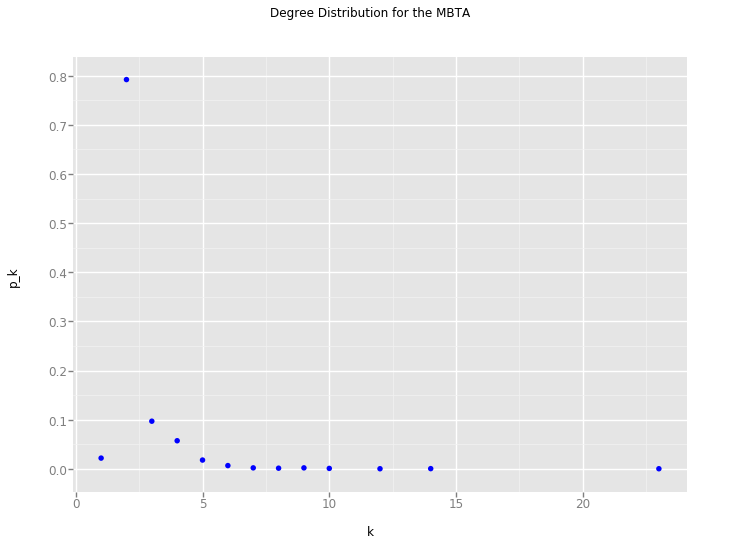

<ggplot: (167109173768)>

In [10]:
degDist=pd.DataFrame(pd.Series(list(dict(G.degree()).values())).value_counts()).reset_index().rename(columns = {'index':'k',0:'p_k'})
degDist.p_k=degDist.p_k/degDist.p_k.sum()
p=ggplot.ggplot(ggplot.aes(x='k',y='p_k'),data=degDist)
print(degDist)
p + ggplot.geom_point(size=30,color='blue') + ggplot.ggtitle('Degree Distribution for the MBTA')

In [190]:
subwayGraph=nx.Graph()
for stop in subwayStopLoc:
    subwayGraph.add_node(stop,Subway=True,loc=subwayStopLoc[stop])
for stop in subwayAdjacencyList:
    for i in range(len(subwayAdjacencyList[stop])): 
            subwayGraph.add_edge(stop,subwayAdjacencyList[stop][i][0],Distance=euclidean_distance(subwayStopLoc[stop],subwayAdjacencyList[stop][i][1]))

['Wood Island', 'Maverick', 'Davis', 'Griggs Street', 'Warren Street', 'Broadway', 'JFK/UMASS', 'State Street', 'Boylston', 'Copley', 'Cedar Grove', 'Shawmut', 'Wellington', 'Sullivan Square', 'Pleasant Street', 'Packards Corner', 'Tufts Medical Center', 'Massachusetts Avenue', 'Riverway', 'Heath Street', 'Revere Beach', 'Suffolk Downs', 'Brookline Hills', 'Reservoir', 'Kenmore', 'Boston Univ East', 'South Street', 'Boston Univ West', 'Blandford Street', 'Boston Univ Central', 'Saint Paul Street', 'Government Center', 'Park Street', 'Arlington', 'Quincy Adams', 'Summit Avenue', 'Fairbanks Street', 'Longwood Medical Area', 'Fenwood Road', 'South Station', 'Andrew', 'Brookline Village', 'Beaconsfield', 'Longwood', 'Milton', 'Valley Road', 'Mattapan', 'Ashmont', 'Butler', 'Harvard', 'Kendall/MIT', 'Newton Centre', 'Chiswick Road', 'Downtown Crossing', 'Sutherland Road', 'Chestnut Hill Avenue', 'Englewood Avenue', 'North Station', 'Hynes', 'Prudential', 'Alewife', 'Porter', 'Tappan Street'

In [42]:
busGraph=nx.Graph()
for stop in busStopLoc:
    busGraph.add_node(stop,Bus=True,loc=busStopLoc[stop])
for stop in busAdjacencyList:
    for i in range(len(busAdjacencyList[stop])):
        busGraph.add_edge(stop,busAdjacencyList[stop][i][0],Bus=True,Distance=euclidean_distance(busStopLoc[stop],busAdjacencyList[stop][i][1]))
 

In [14]:
crGraph=nx.Graph()
for stop in crStopLoc:
    crGraph.add_node(stop,Commuter_Rail=True,loc=crStopLoc[stop])
for stop in crAdjacencyList:
        for i in range(len(crAdjacencyList[stop])):
            crGraph.add_edge(stop,crAdjacencyList[stop][i][0],Commuter_Rail=True,Distance=euclidean_distance(crStopLoc[stop],crAdjacencyList[stop][i][1]))   
print(len(crGraph))

141


In [205]:
# d_ij=max(nx.shortest_path_length(G,'Salem',weight='Distance').values())
# l_ij=euclidean_distance(G.node()['Salem']['loc'],G.node()['Wickford Junction']['loc'])
# l_ij/d_ij
def networkEfficiency2(graph):
    D_ij=0
    L_ij=0
    for node in graph.nodes():
        shortestPath=nx.shortest_path_length(graph,node,weight='Distance')
        d_ij=sum([shortestPath[x]**-1 for x in shortestPath if shortestPath[x]!=0])        
        l_ij=sum([euclidean_distance(graph.node()[node]['loc'],graph.node()[x]['loc'])**-1 for x in graph.nodes() if graph.node()[node]['loc']!=graph.node()[x]['loc']])
        D_ij+=d_ij
        L_ij+=l_ij
    return D_ij/L_ij

def networkEfficiency(graph):
    D_ij=0
    L_ij=0
    for node in graph.nodes():
        shortestPaths=[x for x in nx.shortest_path(graph,node).values() if len(x)>1]
        shortestPaths=[list(zip(x[::1],x[1::1])) for x in shortestPaths]
        d_ij=0
        try:
            d_ij=sum(sum(graph.get_edge_data(y[0],y[1])['Distance'] for y in x if graph.get_edge_data(y[0],y[1])['Distance']>0)**-1 for x in shortestPaths)
        except:
            print(node)
            
        l_ij=sum([euclidean_distance(graph.node()[node]['loc'],graph.node()[x]['loc'])**-1 for x in graph.nodes() if graph.node()[node]['loc']!=graph.node()[x]['loc']])
        D_ij+=d_ij
        L_ij+=l_ij
    return D_ij/L_ij
print(networkEfficiency(busGraph))

Quincy Center Bus
Ashmont
Dorchester Ave @ Hurlcroft Ave
Ruggles
Orient Hts @ Blue Line
Burgin Pkwy @ Quincy Center
Tremont St @ Ruggles St
Orient Heights South
0.479344450675


In [199]:
def networkDebugging(graph):
    D_ij=0
    L_ij=0
    for node_i in graph.node():
        for node_j in graph.node():
            if node_i==node_j or graph.node()[node_i]['loc']==graph.node()[node_j]['loc']:
                continue
            d_ij = nx.shortest_path_length(graph,node_i,node_j,weight='Distance')
            shortestPath = nx.shortest_path(graph,node_i,node_j)
            d_ijCalc=0
            for i in range(1,len(shortestPath)):
                d_ijCalc+=euclidean_distance(graph.node()[shortestPath[i]]['loc'],graph.node()[shortestPath[i-1]]['loc'])
            d_ijReciprocal= d_ij**-1
            l_ij=euclidean_distance(graph.node()[node_i]['loc'],graph.node()[node_j]['loc'])
            l_ijReciprocal= l_ij**-1
            d_ijCalcReciprocal=d_ijCalc**-1
            if d_ijCalc<l_ij:
                print(node_i,node_j)
                print('Shortest path total length: ',d_ij)
                print('calculated shortest path:',d_ijCalc)
                print('Euclidean distance: ',l_ij)

            D_ij+=d_ijCalcReciprocal
            L_ij+=l_ijReciprocal
    return (D_ij/L_ij)

print(networkDebugging(subwayGraph))
            
            
    

0.657676503248


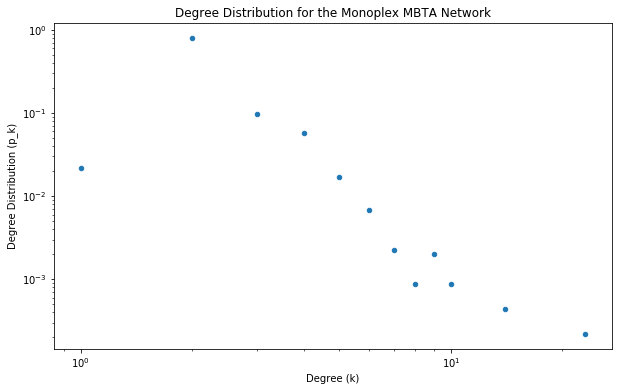

In [229]:
#Full MBTA
n_Full = len(G.nodes())
l_Full = len(G.edges())
C_Full = nx.average_clustering(G)


degDistFull=pd.DataFrame(pd.Series(list(dict(G.degree()).values())).value_counts()).reset_index().rename(columns = {'index':'k',0:'p_k'})
degDistFull.p_k=degDistFull.p_k/degDistFull.p_k.sum()
degDistFull.plot(x='k',y='p_k',kind='scatter',loglog=True,figsize=(10,6))
plt.xlabel('Degree (k)')
plt.ylabel('Degree Distribution (p_k)')
plt.title('Degree Distribution for the Monoplex MBTA Network')

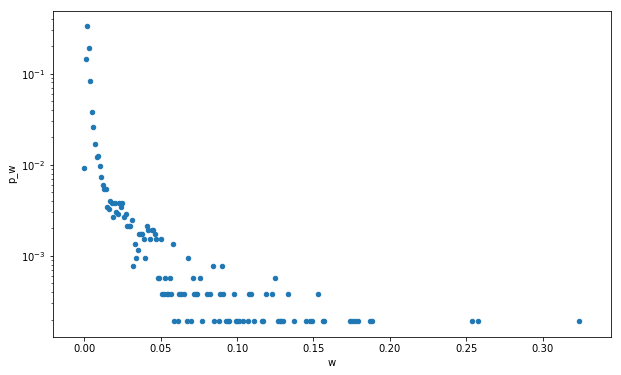

In [235]:
wDistFull=pd.DataFrame(pd.Series([round(G.get_edge_data(e[0],e[1])['Distance'],3) for e in G.edges(data=True)]).value_counts()).reset_index().rename(columns = {'index':'w',0:'p_w'})
wDistFull.p_w=wDistFull.p_w/wDistFull.p_w.sum()
wDistFull.plot(x='w',y='p_w',kind='scatter',logy=True,figsize=(10,6))